# Training models

In [1]:
from data_preprocessing import full_pipeline, splits_to_dataloaders
from random_forest import run_experiment as run_random_forest_experiment
from random_forest import benchmark_random_forest
from xg_boost import run_experiment as run_xgboost_experiment
from nn import run_experiment as run_nn_experiment
from linreg import run_experiment as run_linreg_experiment
from utils import write_submissions
from residual_attention_net import RAMTNet
import torch
import pandas as pd
import numpy as np
import os

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path,
    train_y_path,
    val_proportion=0.4,
    reduce_features=False,
    augment=False,
    apply_feat_eng=False,
    polynomial_degree=2,
    include_group_interactions=False,
    include_humidity_interactions=True,
    feature_selection=False,
    k_features=30,
    remove_outliers=False,
    remove_humidity=True,
)
aug = False
if aug:
    x_train_aug, y_train_aug, x_val_aug, y_val_aug = full_pipeline(
        train_x_path,
        train_y_path,
        val_proportion=0.4,
        reduce_features=False,
        augment=True,
        apply_feat_eng=False,
        polynomial_degree=2,
        include_group_interactions=True,
        include_humidity_interactions=True,
        feature_selection=False,
        k_features=30,
        remove_outliers=False,
        remove_humidity=True,
    )
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)
print("---")
if aug:
    print("X train aug shape:", x_train_aug.shape)
    print("Y train aug shape:", y_train_aug.shape)
    print("X val aug shape:", x_val_aug.shape)
    print("Y val aug shape:", y_val_aug.shape)

X train shape: (121759, 13)
Y train shape: (121759, 23)
X val shape: (81174, 13)
Y val shape: (81174, 23)
---


- High sensor embedding dimension not useful (16 is good). 
- 8 heads too much, 4 enough (even 2 seems ok)
- shared dim 256 better than 128, head dim seems good with shared dim // 2
- 4 res blocks => better results
- Dropout rate: TBD with test perf (0.3 so far)
- Conclusion: Keep quite low dimension before pooling, then larger dim are better.

With these params: 
- with 13 features: 32 sec per epoch. 0.0448 val on 10 epochs. 0.0385 with 20 epochs.
- with 106 features (humidity interactions): 165 sec per epoch. 0.0560

In [3]:
params = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": x_train.drop(columns=["ID"]).shape[1],
        "num_tasks": y_train.shape[1],
        "embed_dim": 16,
        "num_heads": 4,  # 0.0758
        "shared_dim": 256,
        "num_res_blocks": 4,  # 0.0737
        "dropout_rate": 0.3,
        "head_hidden": 128,  # 0.0727
    },
    "training_params": {
        "n_epochs": 20,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 1295863


Epoch 20/20 - Train Loss: 0.0517, Val Loss (weighted): 0.0382, LR: 0.000500: 100%|██████████| 20/20 [12:16<00:00, 36.83s/it]


Validation Weighted RMSE: 0.0382


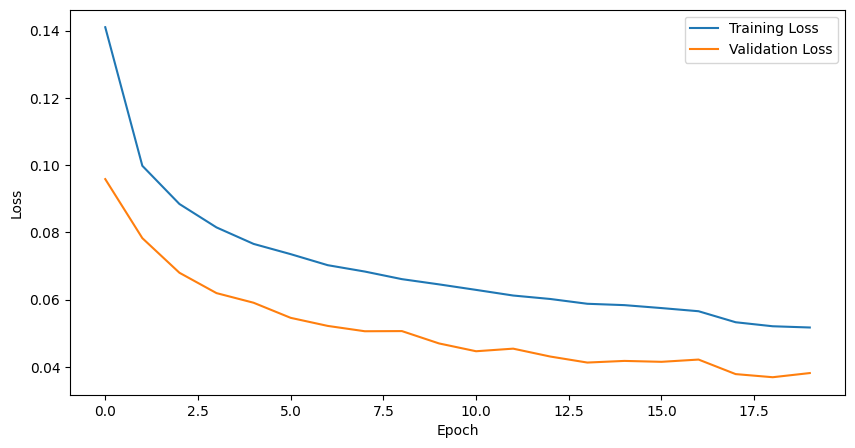

In [ ]:
try:
    ramtnet = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [5]:
torch.save(ramtnet.state_dict(), "ramt_20.pth")

In [5]:
ramtnet = RAMTNet(**params["model_params"])
ramtnet.load_state_dict(torch.load("ramt_20.pth"))

<All keys matched successfully>

In [6]:
write_submissions(
    ramtnet,
    test_x_path,
    "submissions_ramtnet_v1_no_hum.csv",
    apply_feat_eng=False,
    use_embed=False,
    embedder_model=None,
    remove_humidity=True,
)

Using 12 features


<Figure size 1200x1200 with 0 Axes>

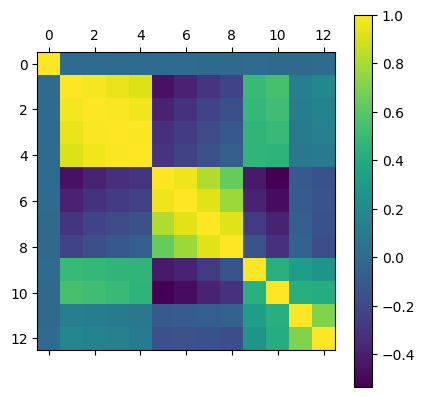

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.matshow(x_train.corr())
plt.colorbar()

In [6]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Training Weighted RMSE: 0.1261
Validation Weighted RMSE: 0.1272


In [10]:
best_params = {
    "n_estimators": 50,
    "max_depth": None,
    "min_samples_split": 0.01,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

best_rf_model = run_random_forest_experiment(
    x_train, y_train, x_val, y_val, params=best_params
)

Training Weighted RMSE: 0.0903
Validation Weighted RMSE: 0.0911


In [6]:
write_submissions(
    best_rf_model,
    test_x_path,
    "submissions_best_rf.csv",
    apply_feat_eng=True,
    use_embed=False,
    embedder_model=None,
)

In [ ]:
# best_model_rf, best_params_rf, best_val_rmse_rf = benchmark_random_forest(x_train, y_train, x_val, y_val, verbose=True)

In [7]:
best_rf_model.predict(x_train.drop("ID", axis=1))[1]

array([1.94254304e-01, 7.14822702e-03, 2.35848465e-01, 2.35848465e-01,
       1.43365455e-03, 1.43365455e-03, 7.14822702e-03, 2.46967612e-05,
       2.10305588e-04, 7.12353026e-03, 7.00007417e-06, 8.58188157e-03,
       3.30122802e-02, 9.60182097e-02, 0.00000000e+00, 4.64609960e-04,
       6.21538518e-03, 9.82290938e-02, 2.70935327e-04, 7.14822702e-03,
       1.43365455e-03, 2.35848465e-01, 2.58510442e-02])

Number of trainable parameters: 16791


Epoch 10/10 - Train Loss: 0.0043, Val Loss (weighted): 0.0461, LR: 0.005000: 100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


Validation Weighted RMSE: 0.0461


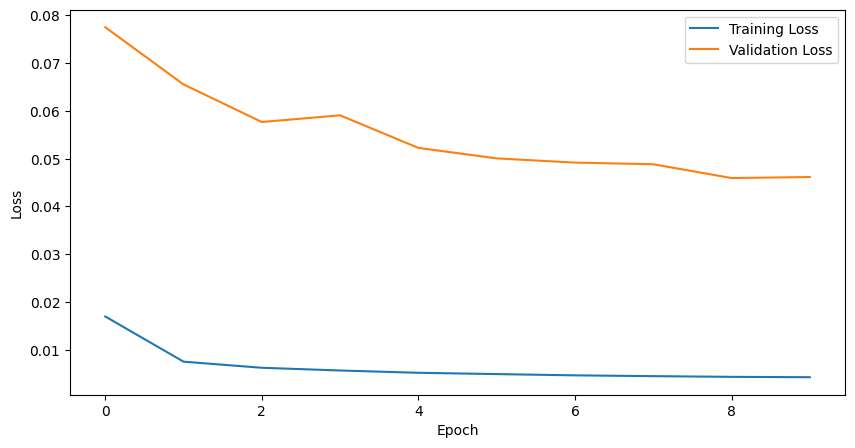

In [5]:
params = {
    "model_class": "NNRegressorV2",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 10,
        "lr": 0.005,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": 3,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "MSELoss",
    },
}
train = True
if train:
    nn_model = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )

In [ ]:
try:
    nn_model_aug = run_nn_experiment(
        x_train_aug,
        y_train_aug,
        x_val,
        y_val,
        params=params,
        verbose=True,
        plot_losses=True,
    )
except KeyboardInterrupt:
    print("Training interrupted by user.")

In [9]:
write_submissions(
    nn_model_aug,
    test_x_path,
    "submissions_gated_nn_aug_v0.csv",
    apply_feat_eng=False,
    use_embed=False,
    embedder_model=None,
)

Using 13 features


Number of trainable parameters: 25391























Epoch 10/10 - Train Loss: 0.0037, Val Loss (weighted): 0.0482, LR: 0.005000: 100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


Validation Weighted RMSE: 0.0482


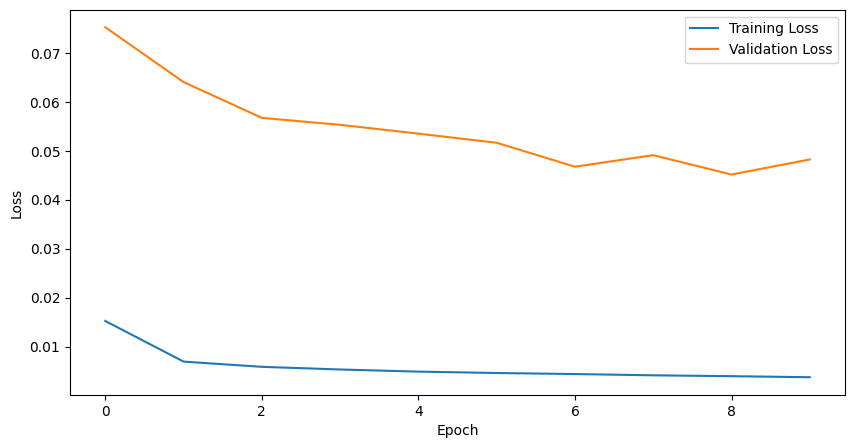

In [10]:
params = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 10,
        "lr": 0.005,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": 3,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "MSELoss",
    },
}
train = True
if train:
    nn_model_gas = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )

Number of trainable parameters: 25391























Epoch 10/10 - Train Loss: 0.0577, Val Loss (weighted): 0.0381, LR: 0.005000: 100%|██████████| 10/10 [03:08<00:00, 18.89s/it]


Validation Weighted RMSE: 0.0381


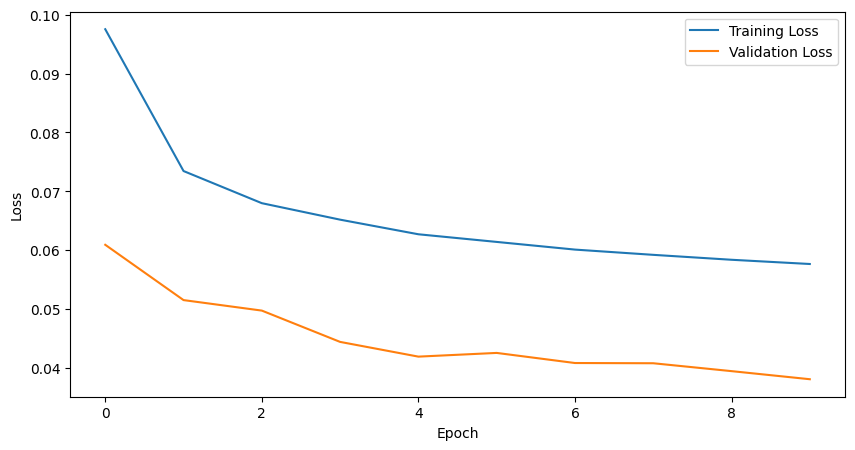

In [12]:
params = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 10,
        "lr": 0.005,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": 3,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}
train = True
if train:
    nn_model_gas_aug = run_nn_experiment(
        x_train_aug,
        y_train_aug,
        x_val,
        y_val,
        params=params,
        verbose=True,
        plot_losses=True,
    )

In [ ]:
"""
try:
    nn_model.eval()
    x_train_torch = torch.tensor(x_train.values, dtype=torch.float32)
    x_val_torch = torch.tensor(x_val.values, dtype=torch.float32)
    with torch.no_grad():
        x_train_emb = nn_model.embed(x_train_torch)
        x_val_emb = nn_model.embed(x_val_torch)
    x_train_emb_df = pd.DataFrame(x_train_emb.numpy(), columns=[f"emb_{i}" for i in range(x_train_emb.shape[1])], index=x_train.index)
    x_val_emb_df = pd.DataFrame(x_val_emb.numpy(), columns=[f"emb_{i}" for i in range(x_val_emb.shape[1])], index=x_val.index)
    x_train_with_emb = pd.concat([x_train, x_train_emb_df], axis=1)
    x_val_with_emb = pd.concat([x_val, x_val_emb_df], axis=1)
except Exception as e:
    print("Error")
    print(e)
    x_train_with_emb = x_train
    x_val_with_emb = x_val
"""

In [5]:
print("2-Stage Linear Model")
try:
    linear_model = run_linreg_experiment(
        x_train_with_emb, y_train, x_val_with_emb, y_val, alpha=0.05
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

2-Stage Linear Model
Training SelectiveLinearRegressor model...


100%|██████████| 23/23 [02:05<00:00,  5.45s/it]


Feature selection results:
c01: 169 features selected - Humidity_x, M12_x, M13_x, M15_x, M4_x, M5_x, M7_x, R_x, S1_x, S2_x, S3_x, M12_15_mean, M12_15_std, M12_15_max, M12_15_min, M12_15_range, M4_7_mean, M4_7_std, M4_7_max, M4_7_min, M4_7_range, RS_mean, RS_std, RS_max, RS_min, RS_range, M12_15_M4_7_ratio, M12_15_RS_ratio, M4_7_RS_ratio, M4_7_RS_product, Humidity_squared, Humidity_sqrt, Humidity_M13_product, Humidity_M14_product, Humidity_M15_product, Humidity_M4_product, Humidity_M5_product, Humidity_M6_product, Humidity_M7_product, Humidity_R_product, Humidity_S1_product, Humidity_S2_product, Humidity_S3_product, Humidity_M12_15_mean_product, Humidity_M12_15_std_product, Humidity_M12_15_max_product, Humidity_M12_15_min_product, Humidity_M12_15_range_product, Humidity_M4_7_mean_product, Humidity_M4_7_std_product, Humidity_M4_7_min_product, Humidity_M4_7_range_product, Humidity_RS_mean_product, Humidity_RS_std_product, Humidity_RS_max_product, Humidity_RS_min_product, Humidity_RS_range

100%|██████████| 23/23 [00:00<00:00, 46.17it/s]


Training Weighted RMSE: 0.1303
Validation Weighted RMSE: 0.1317


In [4]:
write_submissions(
    rf_model,
    test_x_path,
    "submissions_2stage_embed_v0.csv",
    apply_feat_eng=True,
    use_embed=False,
    embedder_model=None,
)

In [16]:
linear_model.predict(x_train.drop("ID", axis=1))[1]

array([ 0.20439817,  0.04268549,  0.41987857,  0.41987857,  0.01369469,
        0.01369469,  0.04268549,  0.01843355, -0.00354795,  0.02435316,
        0.05239958,  0.05648816,  0.15962542,  0.02458648,  0.        ,
        0.00842334, -0.00463618,  0.12753836, -0.02007979,  0.04268549,
        0.01369469,  0.41987857,  0.17860748])

In [ ]:
params = {
    "model_class": "NNRegressorV2",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 15,
        "lr": 0.005,
        "weight_decay": 1e-5,
        "batch_size": 128,
    },
}
nn_model = run_nn_experiment(
    x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
)

Neural Network
Number of trainable parameters: 4247


Epoch 5/5 - Train Loss: 0.0892, Val Loss: 0.0668, LR: 0.010000: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


Validation Weighted RMSE: 0.0668


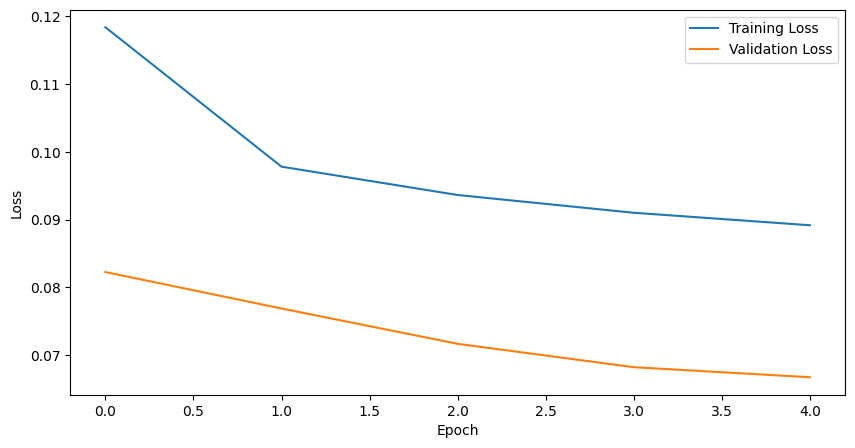

In [7]:
print("Neural Network")
params = {
    "model_class": "NNRegressor",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.2,
    },
    "training_param": {
        "n_epochs": 5,
        "lr": 0.01,
        "weight_decay": 1e-5,
        "batch_size": 128,
    },
}
try:
    nn_model = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )
except KeyboardInterrupt:
    print("Training interrupted.")

Neural Network
Number of trainable parameters: 8943


Epoch 5/5 - Train Loss: 0.1173, Val Loss: 0.1181, LR: 0.010000: 100%|██████████| 5/5 [01:30<00:00, 18.07s/it]


Validation Weighted RMSE: 0.1181


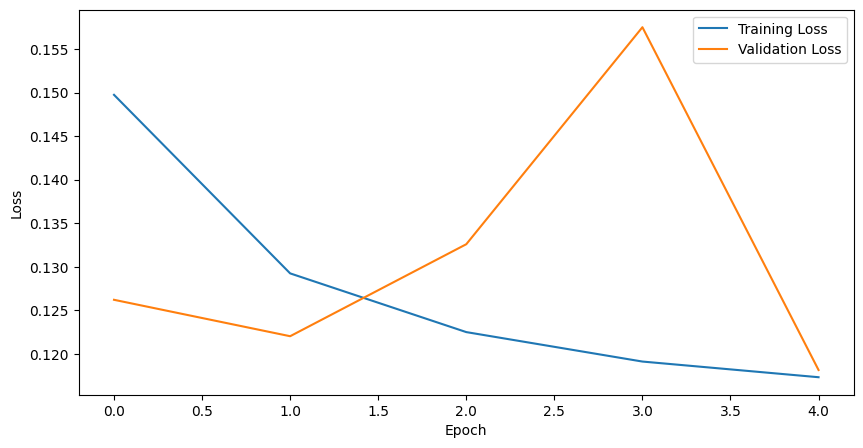

In [3]:
print("Neural Network")
params = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 5,
        "lr": 0.01,
        "weight_decay": 1e-5,
        "batch_size": 128,
    },
}
try:
    nn_model = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )
except KeyboardInterrupt:
    print("Training interrupted.")

In [11]:
import torch

donne = x_val.iloc[0]
nn_model(torch.tensor(donne).float().unsqueeze(0))

/var/folders/l_/mg5njj1n7nl377cq831ycwnc0000gr/T/ipykernel_45880/974138528.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nn_model(torch.tensor(donne).float().unsqueeze(0))


tensor([[3.3021e-01, 4.9465e-03, 5.0988e-01, 5.0988e-01, 4.0155e-02, 4.0155e-02,
         4.9465e-03, 6.2781e-05, 3.5150e-03, 7.0327e-03, 3.8065e-03, 3.4778e-02,
         3.2974e-02, 1.5101e-01, 5.8658e-05, 1.4545e-03, 6.7869e-03, 8.2392e-02,
         5.8408e-04, 4.9465e-03, 4.0155e-02, 5.0988e-01, 2.7343e-02]],
       grad_fn=<SigmoidBackward0>)

Neural Network
Number of trainable parameters: 6551


Epoch 5/5 - Train Loss: 0.0854, Val Loss: 0.0617, LR: 0.010000: 100%|██████████| 5/5 [00:45<00:00,  9.03s/it]


Validation Weighted RMSE: 0.0617


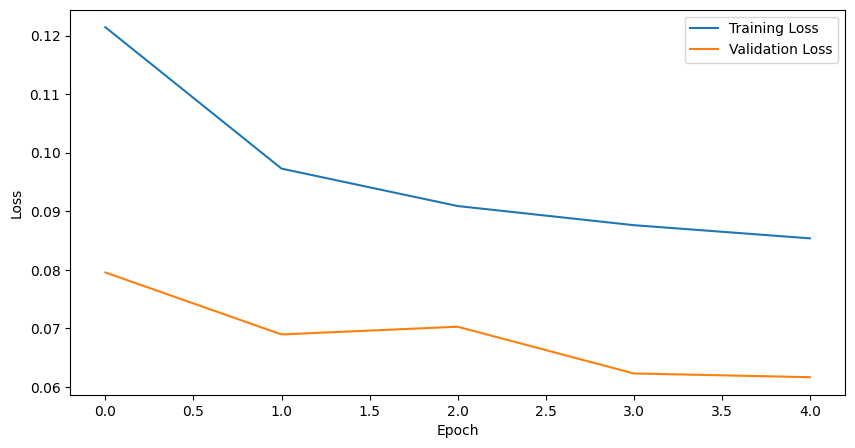

In [9]:
print("Neural Network")
params = {
    "model_class": "NNRegressorV2",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_param": {
        "n_epochs": 5,
        "lr": 0.01,
        "weight_decay": 1e-5,
        "batch_size": 128,
    },
}
try:
    nn_model = run_nn_experiment(
        x_train, y_train, x_val, y_val, params=params, verbose=True, plot_losses=True
    )
except KeyboardInterrupt:
    print("Training interrupted.")

In [11]:
write_submissions(nn_model, test_x_path, "submissions_nn_v1.csv")